In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Parareal
To solve the initial value problem
\begin{align*}
  u_t &= f(t, u), \quad t \in (0, T], \\
  u(0) &= u^0
\end{align*}
using the parareal algorithm, we require two integrators or propagators:
1. $G(t, u)$ is a coarse approximation
2. $F(t, u)$ is a more accurate, or fine, approximation

We partition the time domain into intervals (time-slices, or chunks) and use the coarse approximation $G$ to give us an initial condition for $F$ on each interval.

The more accurate (i.e. _expensive!_) approximation can now be computed in parallel for all slices at once, although obviously the later time slices do not have an accurate initial condition.

We iterate, correcting the initial condition on each interval:
  \begin{align*}
    u_0^{k+1} &= u^0 \\
    u_{n+1}^{k+1} &= F(u_n^k) + G(u_n^{k+1}) - G(u_n^k)
  \end{align*}

We will first apply parareal to the Lorenz63 chaotic system, using an RK4 method for both the coarse and the fine propagators. The coarse propagator will take a larger timestep than the fine. There are functions provided below to compute the right hand side of the Lorenz system and a single RK4 timestep.

In [3]:
def lorenz63(X, sigma=10, beta=8/3, rho=28):
    """
    Given:
       X: a point of interest in three dimensional space
       sigma, rho, beta: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x, y, z = X
    xdot = sigma * (y - x)
    ydot = x*(rho - z) - y 
    zdot = x*y - beta*z
    return np.array([xdot, ydot, zdot])

In [4]:
def rk4(dt, x, f, **f_kwargs):
    """
    A single timestep for rhs function f using RK4
    """
    x1 = f(x, **f_kwargs)  

    x2 = f(x+x1*dt/2.0, **f_kwargs)
    x3 = f(x+x2*dt/2.0, **f_kwargs)
    x4 = f(x+x3*dt, **f_kwargs)
    x_out = x + dt*(x1 + 2*x2 + 2*x3 + x4)/6.0
    return x_out

Let's just run the fine timestepper, since this is a toy problem.

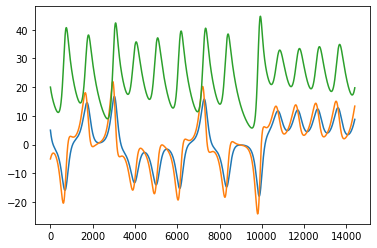

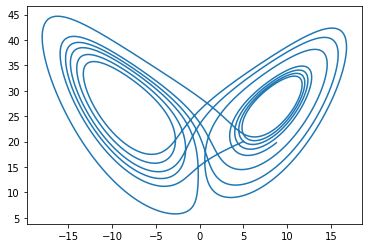

Text(0.5, 0.92, 'Lorenz Attractor')

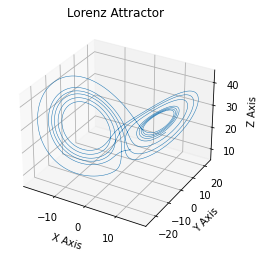

In [11]:
# initial condition
X_n = np.array((5, -5, 20))
X_soln = X0.copy()

# final time
t_max = 10

# total number of fine timesteps
total_Nf = 14400

# fine timestep
dt = t_max/total_Nf

# specify rhs function
rhs = lorenz63

for nsteps in range(total_Nf):
    X_np1 = rk4(dt, X_n, rhs)
    X_soln = np.vstack((X_soln, X_np1))
    X_n = X_np1

# we can plot the time evolution of the coordinates
plt.plot(X_soln[:, 0])
plt.plot(X_soln[:, 1])
plt.plot(X_soln[:, 2])
plt.show()

# or we can plot a 2d xz plot
plt.plot(X_soln[:, 0], X_soln[:, 2])
plt.show()

# or we can plot in 3D
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*X_soln.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

We will reproduce the results from [Gander and Hairer 2007](https://www.unige.ch/~gander/Preprints/gander_plenary2007.pdf), which can also be found in [the parallel in time book](https://www.unige.ch/~gander/poly.pdf). The initial condition and timesteps are given below.

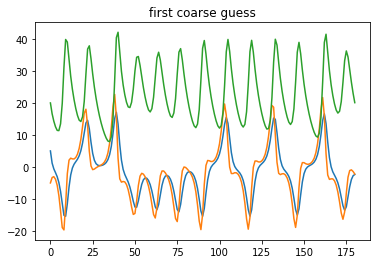

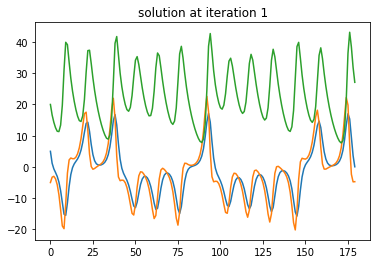

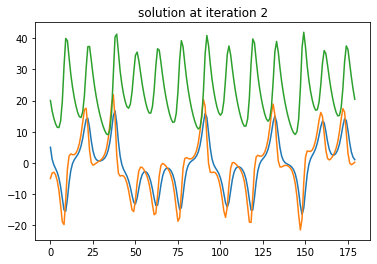

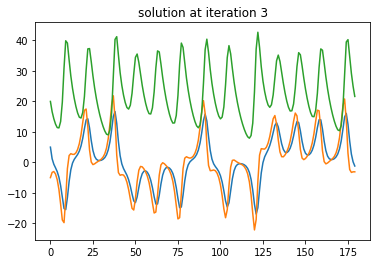

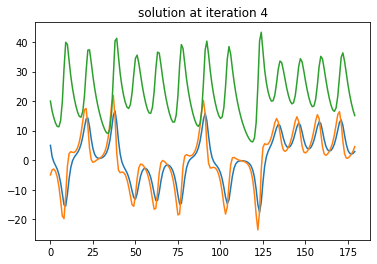

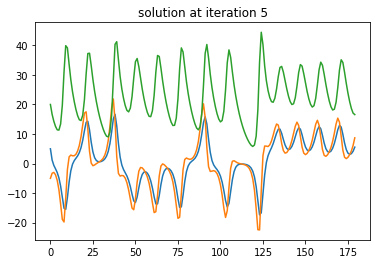

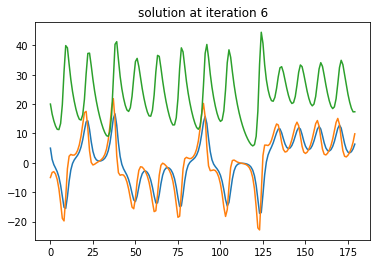

In [36]:
# initial condition
X0 = np.array((5, -5, 20))

# final time
t_max = 10

# total number of coarse timesteps
Nc = 180

# coarse timestep
Dt = t_max/Nc

# total number of fine timesteps
total_Nf = 14400

# number of fine timesteps per coarse timestep
Nf = int(total_Nf/Nc)

# fine timestep
dt = t_max/total_Nf

# specify rhs function
rhs = lorenz63

# Xc_soln will hold our current best solution at each of
# the coarse time levels. Here we copy the initial condition
# to it - we will append values for later coarse times 
# as they are calculated below
Xc_soln = X0.copy()

# We also need the initial condition as the input to our coarse
# propagator
Xc_n = X0

# compute the first iteration using the coarse propagator
for nsteps in range(Nc):
    # this applies one coarse timestep of RK4
    Xc_np1 = rk4(Dt, Xc_n, rhs)
    # we append it to the solution array
    Xc_soln = np.vstack((Xc_soln, Xc_np1))
    Xc_n = Xc_np1

# plot first guess
plt.plot(Xc_soln[:, 0])
plt.plot(Xc_soln[:, 1])
plt.plot(Xc_soln[:, 2])
plt.title("first coarse guess")
plt.show()
    
# number of parareal iterations
nits = 6

# This will hold the values of the fine propagator at the coarse
# times. Since we write to is, rather than update the values, we
# can use np.empty.
Xf = np.empty((Nc, 3))

# The iteration loop using the coarse propagator as an initial condition
# for the fine propagator on each time interval
for k in range(nits):

    # For each time interval we compute the fine solution, starting
    # from our current best solution, stored in Xc_soln. In a
    # parallel implementation this would be shared out with one
    # processor for each time interval.
    for i in range(Nc-1):
        Xf_n = Xc_soln[i,:].copy()
        # This is the fine integrator
        for j in range(Nf):
            Xf_np1 = rk4(dt, Xf_n, rhs)
            Xf_n = Xf_np1
        # Store the final value of the fine integrator
        Xf[i] = Xf_n.copy()

    # Now compute the corrections...
    # Xc_new will hold the corrected values. Copy the initial
    # condition and append to it later, as with Xc_soln
    Xc_new = X0.copy()
    Xc_n = X0
    for i in range(Nc-1):
        # This does G^{k+1} - G^{k} + F^{k}, computing the G values as
        # one coarse timestep of RK4.
        Xc_np1 = rk4(Dt, Xc_n, rhs) - rk4(Dt, Xc_soln[i,:], rhs) + Xf[i]
        Xc_new = np.vstack((Xc_new, Xc_np1))
        Xc_n = Xc_np1
    Xc_soln = Xc_new.copy()
        
    # we can plot the time evolution of the coordinates
    plt.plot(Xc_soln[:, 0])
    plt.plot(Xc_soln[:, 1])
    plt.plot(Xc_soln[:, 2])
    plt.title(f"solution at iteration {k+1}")
    plt.show()

We will now investigate the behaviour of parareal applied to the Dahlquist equation.

## Exercises
1. Apply parareal to the Dahlquist equation with $\lambda=-1$ and initial condition $x=1$. Run until $t=1$ and use 10 coarse timesteps and 20 fine timesteps per coarse timestep.
2. Now set $\lambda=2i$ so that the solution is oscillatory. Investigate the effect of changing the coarse timestep - when does the solution converge? 

In [ ]:
def dahlquist(x, lamda=-1):
    return lamda*x

In [ ]:
def exact_soln(t, lamda):
    return np.exp(lamda*t)